# CI response
## Full-CI response

As we saw in the previous section, for an exact state, we have the formula

$$
  \langle \! \langle \hat{\Omega}; \hat{V}^{\omega} \rangle \!
  \rangle  = -
  \frac{1}{\hbar} \sum_{n>0} \left[
  \frac{\langle 0 | \hat{\Omega}  | n \rangle 
\langle n | \hat{V}^{\omega} | 0 \rangle }
       {\omega_{n0}-\omega}
+
  \frac{\langle 0 | \hat{V}^{\omega}  | n \rangle 
\langle n | \hat{\Omega} | 0 \rangle }
       {\omega_{n0}+\omega} \right] 
$$

For example, in the case of a molecule irradiated by light, we are interested in computing the polarizability $\alpha_{\alpha\beta}(-\omega; \omega)$, corresponding to the response with $\hat{\Omega} = \hat{\mu}_\alpha$ and $\hat{V}^\omega = - \hat{\mu}_\beta$, where $\alpha, \beta \in \{x,y,z\}$. Looking more precisely at the isotropic component, $\bar\alpha (-\omega; \omega) = \frac{1}{3} \sum_\alpha \alpha_{\alpha\alpha} (-\omega; \omega)$, we obtain

$$
  \bar\alpha (-\omega; \omega) = \frac{2}{3} \sum_{n>0} \sum_\alpha \frac{ \omega_{n0} | \langle 0 | \hat{\mu}_\alpha  | n \rangle |^2 }{ \omega_{n0}^2 - \omega^2 }
$$

We now define the oscillator strength $f_n$ for a transition $0 \rightarrow n$ as

$$
  f_n =  \frac{2}{3} \sum_\alpha \omega_{n0} | \langle 0 | \hat{\mu}_\alpha  | n \rangle |^2
$$

such that

$$
  \bar\alpha (-\omega; \omega) =  \sum_{n>0}  \frac{ f_n }{ \omega_{n0}^2 - \omega^2 }
$$

Those formulas can be applied directly for a configuration interaction wave function, where it is easy to get the excited state energies simply by obtaining additional roots in the diagonalization of the Hamiltonian. We then only need to compute the matrix element $\langle 0 | \hat{\mu}_\alpha  | n \rangle$. In second quantization, the $\alpha$ component of the dipole operator can be written as

$$
\hat{\mu}_{\alpha} = \sum_{pq} \mu_{\alpha, pq} \hat{a}_p^\dagger \hat{a}_q 
$$

We thus need to compute the matrix $\boldsymbol{\gamma}$, with elements $ \gamma_{pq} =\langle 0 |\hat{a}_p^\dagger \hat{a}_q | n \rangle$, which is called the _transition density matrix_, and contract it with the dipole moment integrals.


Let's apply these for full CI (FCI) of a water molecule.

In [1]:
import veloxchem as vlx
import multipsi as mtp
import numpy as np

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
mol_str = """3

O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

molecule = vlx.Molecule.read_xyz_string(mol_str)
basis = vlx.MolecularBasis.read(molecule, "6-31g")
scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /opt/anaconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G        
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [3]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(mol_str, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.rotate(-90,'x')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
# Compute the 5 lowest states of water using full CI

space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
# Full CI with frozen 1s orbital
space.fci(n_frozen=1)

nstates=5
cidrv=mtp.CIDriver()
ci_results = cidrv.compute(molecule,basis,space,nstates)
CIVecs = cidrv.vecs

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 1
Number of active orbitals:              12
Number of virtual orbitals:             0

    This is a CASSCF wavefunction: CAS(8,12)

          CI expansion:
          -------------
Number of determinants:      122760


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
          Max. iterations         : 40
          Initial diagonalization : 200
          Max subspace size       : 50
          Convergence thresholds:
            - Energy change       : 1e-08
            - Residual square norm: 1e-08
          Standard Davidson step
                                                                             

In [5]:
au2ev = 27.211386

# Get the molecular orbitals within the active space
C=space._get_active_mos()

# Compute dipole integrals in AO basis
dipole_drv = vlx.ElectricDipoleIntegralsDriver()
dipole_mats = dipole_drv.compute(molecule, basis)
dipole=[dipole_mats.x_to_numpy(),dipole_mats.y_to_numpy(),dipole_mats.z_to_numpy()]

# Transform to MO basis
dipole_mo=[]
for icomp in range(0,3):
    dipole_mo.append(np.einsum('pq,pt,qu->tu', dipole[icomp], C, C))
    

# Initialize the CIOperator class to compute the transition densities.
expansion=mtp.CIExpansion(space)
DenDriver=mtp.CIOperator(expansion)
        
# Compute all 0->n transitions
for n in range(1,nstates):
    dE=CIVecs[n].energy-CIVecs[0].energy
    tden=DenDriver.get1den(CIVecs[0],CIVecs[n]) #Transition density matrix
    dx=np.tensordot(tden,dipole_mo[0]) #<0|x|n>
    dy=np.tensordot(tden,dipole_mo[1]) #<0|y|n>
    dz=np.tensordot(tden,dipole_mo[2]) #<0|z|n>
    F=2/3*dE*(dx*dx+dy*dy+dz*dz)
    print(f"Excitation 0->{n} energy: {dE*au2ev:5.3f} eV oscillator strength: {F:.5f}")

Excitation 0->1 energy: 8.450 eV oscillator strength: 0.01319
Excitation 0->2 energy: 10.685 eV oscillator strength: 0.00000
Excitation 0->3 energy: 10.977 eV oscillator strength: 0.11535
Excitation 0->4 energy: 13.377 eV oscillator strength: 0.11499


We thus obtain 3 visible transitions and one dark state (near-zero dipole oscillator strength). We obtain the exact same result by using the built-in class of multipsi:

In [6]:
SI=mtp.InterState()
DipOsc=SI.compute(molecule, basis, ci_results)

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2        8.44992         1.318937e-02    4.625297e-02
     1       4       10.97654         1.153538e-01    1.749710e-01
     1       5       13.37692         1.149882e-01    1.223962e-01
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)


## Truncated CI response

While they do not formally qualify as "exact state", the response equations for truncated CI are the same as the exact case above. One can thus, in principle, obtain a hierarchy of method from CIS to full CI. However, the excitation energies do not necessarily improve from order to order. Let us demonstrate this on the water example.

In [7]:
nstates=5
# nstates-1 transitions for CIS, CISD, CISDT and CISDTQ and FCI
Energies=np.empty((5,nstates-1))
Energies[4,:]=au2ev*DipOsc['energies'] # Save the FCI result

#CIS to CISDTQ
space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
cidrv=mtp.CIDriver()
SI=mtp.InterState()

for exc in range(1,5):
    space.ci(exc,n_frozen=1)
    ci_results = cidrv.compute(molecule,basis,space, nstates)
    DipOsc=SI.compute(molecule,basis,ci_results)
    Energies[exc-1,:]=au2ev*DipOsc['energies']

                          Configuration Interaction Driver
                                                                                                                          

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 1
Number of active orbitals:              12
Number of virtual orbitals:             0

    This is a GASSCF wavefunction

         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1           4               7                8
     2          12               8                8


          CI expansion:
          -------------
Number of determinants:      33


        ╭────────────────────────────────────╮
        │          Driver settings           │
        ╰────────────────────────────────────╯
         Solved by explicit diagonalization
                                                                                                          

                                                                                                                          
List of oscillator strengths greather than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Oscillator strength (length and velocity)
     1       2       10.29159         1.548866e-02    3.658376e-02
     1       4       12.78501         1.247451e-01    1.355482e-01
     1       5       15.12866         1.136810e-01    9.274229e-02
                                                                                                                          
List of rotatory strengths greater than 1e-10
                                                                                                                          
  From     to       Energy (eV)    Rot. strength (a.u. and 10^-40 cgs)
                          Configuration Interaction Driver
     

        6     -75.799446125    -9.5e-06      3.3e-06   0:00:08
        7     -75.799446623    -9.0e-07      5.5e-07   0:00:08
        8     -75.799446711    -2.5e-07      2.1e-07   0:00:08
        9     -75.799446734    -9.2e-08      6.1e-08   0:00:07
       10     -75.799446738    -2.0e-08      7.4e-09   0:00:07
       11     -75.799446739    -2.1e-09      8.5e-10   0:00:10
                                                                                                                          
** Convergence reached in 11 iterations
                                                                                                                          
        Final results
        -------------
                                                                                                                          
                                                                                                                          
* State 1
- Energy: -76.12003281964515
- S^2  

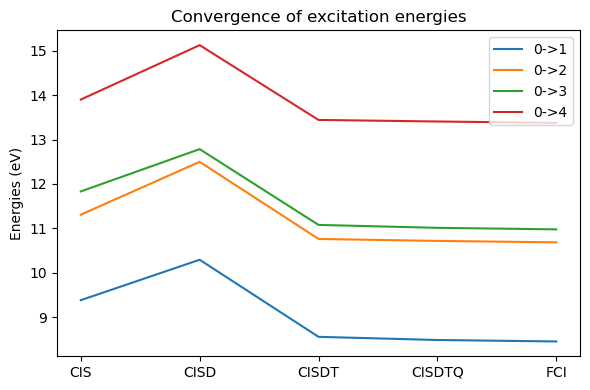

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
x = np.array(range(1,6))
plt.plot(x,Energies[:,0], label='0->1')
plt.plot(x,Energies[:,1], label='0->2')
plt.plot(x,Energies[:,2], label='0->3')
plt.plot(x,Energies[:,3], label='0->4')

plt.title('Convergence of excitation energies')
plt.xticks([1, 2, 3, 4, 5], ['CIS', 'CISD', 'CISDT', 'CISDTQ', 'FCI'])
plt.ylabel("Energies (eV)")
plt.legend()
plt.tight_layout(); plt.show()

In [9]:
Energies[0,:]

array([ 9.38058973, 11.30738694, 11.83172339, 13.90237127])

As we can see, we do not have a monotonous convergence towards the full CI result. In particular, CISD is actually worse than CIS. The reason for this is that CIS has a more even-handed treatment of the ground and excited states than CISD. In CIS, due to the Brillouin theorem, the ground state does not improve with the inclusion of single excitations, but the single excitations are needed to generate the dominant configuration for the (singly) excited states. Both ground and excited states are thus treated at a mean-field (HF-like) level.

However, in CISD, the ground state contains double excitation, and thus dynamical correlation, while the excited states would need up to triple excitations to both generate the singly-excited dominant configuration and correlating double excitations on top. There is an unbalance, the ground state being described more accurately than the excited states, leading to too high excitation energies. Adding the triple excitations bring correlation also for excited states, which brings the result closer to the final FCI result, and in this simple case is essentially converged.

For this reason, while CIS is sometimes used to compute excitation energies (and as we can see in the next section, is actually related to HF response), the other truncated CIs are not.